# DroneLeader Architecture

We envision a multi-agent organization whereby:

* A Strategist directs multiple Teams through Tasks/Objectives.

* Each Team is made up of agents of different types (drones and crawlers) and roles (leaders and followers).

* A Team uses its Culture to shape its agents' behaviors by doling out behavorial rewards during training. It uses its Mission to help its agents learn abilities to accomplish individual or group objectives by doling out mission rewards during training.

* In this way, a Strategist that is optimized for strategic decision making can analyze the games space and direct multiple Teams to accomplish more complex and strategic tasks that require more than behavioral skills.

However, we are not able to reliably train droneleaders with simple 2-layer FC-Softmax policies to learn how to minimize the delta between the drone's coordinate and the target coordinate of max favoribility given by the Strategist.

We will implement several different drone leaders to find out which is the most reliable:

- DroneLeader_FC32: a 2 layer FC-Softmax (32 hidden units) policy with the deltas (between drone and target coordinates) as input
- DroneLeader_FC64: a 2 layer FC-Softmax (64 hidden units) policy with the deltas (between drone and target coordinates) as input
- DroneLeader_CNN1: a CNN policy with a 1-frame game space of drone and goal locations as input

In [1]:
import os
import random
import time
import platform
import torch
import torch.optim as optim
import gym
import numpy as np
import pickle

# This is the Crossing game environment
from xteams_env import CrossingEnv
from xteams_model import *
from interface import *

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))
print("OpenAI Gym version: {}".format(gym.__version__))

Python version:  3.6.4
Pytorch version: 0.4.1.post2
OpenAI Gym version: 0.9.2


## Strategist Class

(Wikipedia) A strategist is responsible for the formulation and implementation of a strategy. Strategy generally involves setting goals, determining actions to achieve the goals, and mobilizing resources to execute the actions. It describes how the ends (goals) will be achieved by the means (resources).

An agent belonging to the Strategist class performs the following:

(1) It accepts and abdicates responsibilities for directing teams of agents

(2) It receives game space and metrics from the Environment

(3) It analyzes the game space and metrics to arrive at a "strategic position" for its teams. e.g. a topological map and/or a set of game stats

(4) Based on the strategic position, it decides on a set of goals that need to be accomplished

(5) It surveys its teams of agents and their location in the games space

(6) For each goal, it picks the best team and assign it the goal

(7) If necessary, it reorganize the teams and the agents

(8) It measures the effectiveness of the teams in accomplishing the assigned goals, and whether the "strategic position" has improved for its teams


# Train Team directed by Strategist

For now, a strategist can only direct 1 team with a drone agent, which acts as the "eye" for the strategist. The strategist access the game space through the complete obs space of the drone agent.

The code below run training on 2 teams of 5 Agents each. Both team Viking and Franks have Pacifist cultures so they are unagressive (do not fire their lasers). The Vikings have a drone leader and a strategist. The Franks do not.

Our strategist is able to take in the game space provided by its eye and output a goal in the form of a coordinate. 

The Team class must now take this goal ("move the team to this coordinate") and generate the mission reward such that its leader agent learns to move to that coordinate, thus taking many of its followers along in its target zone.


## DroneLeader_FC32 and DroneLeader_FC64

The DroneLeader_FC32 is a 2-layer fully-connected NN with 32 hidden units that accepts the normalized deltas between the droneleader's coordinate vs the target coordinate of max favorability as input to output an action.

The DroneLeader_FC64 is a 2-layer fully-connected NN with 64 hidden units.

In [3]:
num_drone_actions = 12
num_goal_params = 2

drone_leader = DroneLeader_FC32(num_goal_params, num_drone_actions, 0)
print (drone_leader)

batch_size = 1
x = torch.randn(batch_size, 2)
output = drone_leader(x)
print(output)

drone_leader = DroneLeader_FC64(num_goal_params, num_drone_actions, 0)
print (drone_leader)

batch_size = 1
x = torch.randn(batch_size, 2)
output = drone_leader(x)
print(output)

DroneLeader_FC32(
  (features): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU(inplace)
  )
  (action_head): Linear(in_features=32, out_features=12, bias=True)
)
tensor([[0.0782, 0.1387, 0.0621, 0.0547, 0.0694, 0.0692, 0.1014, 0.0987, 0.1282,
         0.0692, 0.0596, 0.0705]], grad_fn=<SoftmaxBackward>)
DroneLeader_FC64(
  (features): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace)
  )
  (action_head): Linear(in_features=64, out_features=12, bias=True)
)
tensor([[0.0741, 0.0707, 0.1195, 0.0622, 0.0982, 0.0790, 0.1015, 0.0696, 0.0872,
         0.1058, 0.0614, 0.0707]], grad_fn=<SoftmaxBackward>)


## Training - DroneLeader_FC32


In [6]:
import sys
from collections import deque
from torch.autograd import Variable

# Initialize environment
game = "Crossing"
num_crawler_actions = 8                     # Crawlers are capable of 8 actions
num_drone_actions = 12                      # Drones are capable of 12 actions
num_goal_params = 2    # Goal has 2 parameter

experiment = '1T-1L/strategist/'    # 1 team of 1 drone leader directed by a strategist

# Map and Parameter sets
map_name = "food_d37_river_w1_d25"  
parameters =[ 
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, \
             'game_steps':300, 'seed': 0},
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, \
             'game_steps':300, 'seed': 7},
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, \
             'game_steps':300, 'seed': 54}
            ]

temp_end = 1.0   # temp parameter is annealed from the value stored in parameters['temp_start'] to 1.0 

# Initialize training parameters
warm_start = False
num_frames = 7      # environ observation consists of a list of stacked frames per agent
max_episodes = 2000

render = True    # This turns on rendering every save so that agents' behavior can be observed
SPEED = 1/30
second_pile_x = 50  # x-coordinate of the 2nd food pile

log_interval = 10
save_interval = 20

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-2

# Initialize agents parameters
#   1 agents - 1 learning agents, 0 trained agent, 0 random agent
num_learners = 1
num_trained = 0
num_rdn = 0

num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# The main code starts here!!!

for parameter in parameters:   # Go down the list of parameter sets
    
    start = time.clock()  # time the training
    
    torch.manual_seed(parameter['seed'])
    situation = 'droneleaderfc32_seed_'+str(parameter['seed'])
    temp_start = parameter['temp_start']
    river_penalty = parameter['river_penalty']
    max_frames = parameter['game_steps']
    
    # Set up parameters of agents and teams as inputs into CrossingEnv
    teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},
    ]
    agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (3,9)},
    ]

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    deltas = []   # 6-2-2019 delta coordinates
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            
            print("Learner agent {}".format(i))
            
            # Initialize agent policy based on type
            if agents_params[i]['type'] is 'crawler':
                agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'follower':
                agents.append(Drone_Policy(num_frames, num_drone_actions, i)) 
            elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                print("Load Drone Leader.")
                agents.append(DroneLeader_FC32(num_goal_params, num_drone_actions, i)) 
            else:
                raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
            
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("Learning with trained agents - not implemented yet!")
            raise
            """
            Disable for now! No need to train with trained agents.
            agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]
        deltas = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)
        
        # 6-2-2019 Keep track of distance from goal achieved by droneleader
        episode_delta = 0   # distance from goal for an episode
        running_delta = None   # running distance from goal
        running_deltas = []    # history of running distance from goal
        best_delta = 0    # best running distance from goal (for storing best_model)        
        
        # Keep track of num learners who has crossed over to the 2nd food pile
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode
        running_crossed = None         # running average
        running_crossed_hist = []   # history of running averages

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Crawler_Policy(input_channels=num_frames, num_actions=num_crawler_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """
    # Attach agents to their teams
    # 4-28-2019 Add roles and types to enable multi-role teams

    teams = []
    # Team Vikings
    teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'], \
                  culture=teams_params[0]['culture'], roles=teams_params[0]['roles'], \
                  agent_policies=[agents[0]], \
                  agent_roles = [agent['role'] for agent in agents_params[0:1]]))
    
    # 5-30-2019  Strategist accepts directorship of a team
    suntzu = Strategist()
    suntzu.accept(teams[0])   # Strategist accepts directorship of Team Viking
    
    env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_window = False)   
    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with Crawler_Policy
        agents_obs = unpack_env_obs(env_obs)
        
        # 5-30-2019 Strategist uses the obs space of its team eye as the big picture
        game_space = agents_obs[suntzu.eyes[0].idx]
        goals, topology = suntzu.generate_goals(game_space)
        deltas = calc_norm_deltas(goals[0], env.agent_locations[0])
        agents[0].deltas.append(deltas)   # Store a history of deltas for generating mission rewards

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        # Initialize reward and agents crossed counters
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        episode_delta = 0                               # distance from goal for an episode
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode
    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                if agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                    # 6-02-2019 Simple droneleaders do not require obs space as input
                    actions[i], log_probs[i] = select_action_strat_simple(agents[i], deltas, cuda)
                else:    
                    actions[i], log_probs[i] = select_action(agents[i], agents_obs[i], cuda)
                
                # Only crawlers can fire lasers
                if agents_params[i]['type'] is 'crawler':
                    if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                        tags[i] += 1   # record a tag for accessing aggressiveness
                        
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with Crawler_Policy
            agents_obs = unpack_env_obs(env_obs)
            
            load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
            
            # 5-30-2019 Strategist uses the obs space of its team eye as the big picture
            game_space = agents_obs[suntzu.eyes[0].idx]
            goals, topology = suntzu.generate_goals(game_space)
            deltas = calc_norm_deltas(goals[0], env.agent_locations[0])
            agents[0].deltas.append(deltas)   # Store a history of deltas for generating mission rewards

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """
            
            if render and (ep % save_interval == 0):   # render 1 episode every save
                env.render()
                time.sleep(SPEED)  # Change speed of video rendering

            if any(done):
                print("Done after {} frames".format(frame))
                break

        # Keep track num of agents who gather from 2nd food pile. Note that env.consumption tracks the 
        # agent index and location of apple gathered
        for (i, loc) in env.consumption:
            if loc[0] > second_pile_x:   # If x-cood of gathered apple is beyond a preset value, it is
                                         # in the 2nd pile
                crossed[i] = 1
        episode_crossed = sum(crossed)   # sum up the num agents who crossed to 2nd pile for the episode
                
        # Update reward and crossed statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])
            
        if running_crossed is None:
            running_crossed = episode_crossed
        running_crossed = running_crossed * 0.99 + episode_crossed * 0.01
        running_crossed_hist.append(running_crossed)
        
        # 6-02-2019 Update distance from goal for droneleader
        target_x, target_y = goals[0]
        current_x, current_y = env.agent_locations[0]
        episode_delta = abs(target_x - current_x) + abs(target_y - current_y)
        
        if running_delta is None:
            running_delta = episode_delta
        running_delta = running_delta * 0.99 + episode_delta * 0.01
        running_deltas.append(running_delta)
        
                
        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                verbose_str += '\tNum agents crossed: {}'.format(episode_crossed)
                verbose_str += '\tRunning mean: {:.4}'.format(running_crossed)
                verbose_str += '\tDelta total:{}'.format(episode_delta)
                verbose_str += '\tRunning mean: {:.4}'.format(running_delta)
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(teams, agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])

        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'models/' + experiment + map_name
                results_dir = 'results/' + experiment + map_name

                model_file = model_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}_ep{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game, ep+prior_eps+1)
                data_file = results_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game)

                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    save_model(f, ep, agents[i], optimizers[i])

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
             
            crossed_file = results_dir+'/{}/t{}_rp{}_{}gs/Crossed.p'.format(situation, \
                        temp_start, river_penalty, max_frames)
            os.makedirs(os.path.dirname(crossed_file), exist_ok=True)
            with open(crossed_file, 'wb') as f:
                    pickle.dump(running_crossed_hist, f)

            delta_file = results_dir+'/{}/t{}_rp{}_{}gs/Delta.p'.format(situation, \
                        temp_start, river_penalty, max_frames)
            os.makedirs(os.path.dirname(delta_file), exist_ok=True)
            with open(delta_file, 'wb') as f:
                    pickle.dump(running_deltas, f)

    end = time.clock()
    print('\nTraining time: {:.2f} min'.format((end-start)/60.0))
            
    env.close()  # Close the environment

Learner agent 0
Load Drone Leader.
..........
Episode 10 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:61	Running mean: 42.17
Max Norms =  ['22.96']
..........
Episode 20 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:58	Running mean: 43.92
Max Norms =  ['20.21']
..........
Episode 30 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:58	Running mean: 45.63
Max Norms =  ['14.24']
..........
Episode 40 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:56	Running mean: 47.09
Max Norms =  ['20.40']
..........
Episode 50 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:67	Running mean: 48.01
Max Norms =  ['19.13']
..........
Episode 60 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running m

..........
Episode 490 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:8	Running mean: 7.539
Max Norms =  ['14.38']
..........
Episode 500 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:7	Running mean: 7.392
Max Norms =  ['5.49']
..........
Episode 510 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:3	Running mean: 7.124
Max Norms =  ['24.69']
..........
Episode 520 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 6.836
Max Norms =  ['6.19']
..........
Episode 530 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:8	Running mean: 6.891
Max Norms =  ['15.60']
..........
Episode 540 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean:

..........
Episode 970 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:9	Running mean: 7.862
Max Norms =  ['41.46']
..........
Episode 980 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:7	Running mean: 7.883
Max Norms =  ['22.75']
..........
Episode 990 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:9	Running mean: 7.915
Max Norms =  ['13.49']
..........
Episode 1000 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:8	Running mean: 7.931
Max Norms =  ['30.59']
..........
Episode 1010 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:9	Running mean: 7.94
Max Norms =  ['16.38']
..........
Episode 1020 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:9	Running m

..........
Episode 1450 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 6.166
Max Norms =  ['20.89']
..........
Episode 1460 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:7	Running mean: 6.169
Max Norms =  ['24.09']
..........
Episode 1470 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 6.171
Max Norms =  ['7.93']
..........
Episode 1480 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:5	Running mean: 6.164
Max Norms =  ['9.72']
..........
Episode 1490 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:5	Running mean: 6.205
Max Norms =  ['23.50']
..........
Episode 1500 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running

..........
Episode 1930 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:9	Running mean: 6.964
Max Norms =  ['22.66']
..........
Episode 1940 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:9	Running mean: 7.159
Max Norms =  ['14.72']
..........
Episode 1950 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:9	Running mean: 7.335
Max Norms =  ['13.56']
..........
Episode 1960 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:8	Running mean: 7.474
Max Norms =  ['10.36']
..........
Episode 1970 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:5	Running mean: 7.417
Max Norms =  ['6.01']
..........
Episode 1980 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Runnin

..........
Episode 410 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:10	Running mean: 10.72
Max Norms =  ['23.29']
..........
Episode 420 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 10.33
Max Norms =  ['14.16']
..........
Episode 430 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:4	Running mean: 9.948
Max Norms =  ['19.08']
..........
Episode 440 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 9.696
Max Norms =  ['19.65']
..........
Episode 450 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:9	Running mean: 9.44
Max Norms =  ['17.87']
..........
Episode 460 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:7	Running mea

..........
Episode 890 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:8	Running mean: 6.562
Max Norms =  ['31.37']
..........
Episode 900 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:5	Running mean: 6.546
Max Norms =  ['19.76']
..........
Episode 910 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 6.486
Max Norms =  ['30.26']
..........
Episode 920 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:8	Running mean: 6.44
Max Norms =  ['24.94']
..........
Episode 930 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 6.417
Max Norms =  ['12.44']
..........
Episode 940 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:5	Running mean

..........
Episode 1370 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 6.039
Max Norms =  ['19.86']
..........
Episode 1380 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:5	Running mean: 5.996
Max Norms =  ['14.02']
..........
Episode 1390 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 5.997
Max Norms =  ['15.19']
..........
Episode 1400 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 5.997
Max Norms =  ['18.23']
..........
Episode 1410 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:7	Running mean: 5.97
Max Norms =  ['17.31']
..........
Episode 1420 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:5	Runnin

..........
Episode 1850 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:5	Running mean: 5.748
Max Norms =  ['7.45']
..........
Episode 1860 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 5.781
Max Norms =  ['44.97']
..........
Episode 1870 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:5	Running mean: 5.811
Max Norms =  ['9.10']
..........
Episode 1880 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:5	Running mean: 5.781
Max Norms =  ['1.34']
..........
Episode 1890 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:7	Running mean: 5.773
Max Norms =  ['18.33']
..........
Episode 1900 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running 

..........
Episode 330 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:9	Running mean: 15.0
Max Norms =  ['21.61']
..........
Episode 340 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 14.31
Max Norms =  ['20.16']
..........
Episode 350 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:8	Running mean: 13.66
Max Norms =  ['21.60']
..........
Episode 360 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:7	Running mean: 13.04
Max Norms =  ['11.30']
..........
Episode 370 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:7	Running mean: 12.55
Max Norms =  ['18.22']
..........
Episode 380 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:9	Running mean

..........
Episode 810 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 6.923
Max Norms =  ['39.43']
..........
Episode 820 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 6.834
Max Norms =  ['20.04']
..........
Episode 830 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:8	Running mean: 6.85
Max Norms =  ['16.58']
..........
Episode 840 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 6.816
Max Norms =  ['35.45']
..........
Episode 850 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 6.777
Max Norms =  ['23.13']
..........
Episode 860 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean

..........
Episode 1290 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:3	Running mean: 3.031
Max Norms =  ['31.31']
..........
Episode 1300 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:4	Running mean: 3.058
Max Norms =  ['35.76']
..........
Episode 1310 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:1	Running mean: 3.052
Max Norms =  ['24.64']
..........
Episode 1320 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:3	Running mean: 2.98
Max Norms =  ['40.08']
..........
Episode 1330 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:4	Running mean: 2.984
Max Norms =  ['59.05']
..........
Episode 1340 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:4	Runnin

..........
Episode 1770 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:1	Running mean: 2.096
Max Norms =  ['73.44']
..........
Episode 1780 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:1	Running mean: 2.029
Max Norms =  ['29.84']
..........
Episode 1790 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:3	Running mean: 2.094
Max Norms =  ['34.01']
..........
Episode 1800 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:3	Running mean: 2.093
Max Norms =  ['25.37']
..........
Episode 1810 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:2	Running mean: 2.141
Max Norms =  ['21.10']
..........
Episode 1820 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:3	Runni

## Training - DroneLeader_FC64

Train DroneLeader_FC64 from 1 start point on the same map.

In [ ]:
import sys
from collections import deque
from torch.autograd import Variable

# Initialize environment
game = "Crossing"
num_crawler_actions = 8                     # Crawlers are capable of 8 actions
num_drone_actions = 12                      # Drones are capable of 12 actions
num_goal_params = 2    # Goal has 2 parameter

experiment = '1T-1L/strategist/'    # 1 team of 1 drone leader directed by a strategist

# Map and Parameter sets
map_name = "food_d37_river_w1_d25"  
parameters =[ 
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, \
             'game_steps':300, 'seed': 0},
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, \
             'game_steps':300, 'seed': 7},
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, \
             'game_steps':300, 'seed': 54}
            ]

temp_end = 1.0   # temp parameter is annealed from the value stored in parameters['temp_start'] to 1.0 

# Initialize training parameters
warm_start = False
num_frames = 7      # environ observation consists of a list of stacked frames per agent
max_episodes = 2000

render = True    # This turns on rendering every save so that agents' behavior can be observed
SPEED = 1/30
second_pile_x = 50  # x-coordinate of the 2nd food pile

log_interval = 10
save_interval = 20

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-2

# Initialize agents parameters
#   1 agents - 1 learning agents, 0 trained agent, 0 random agent
num_learners = 1
num_trained = 0
num_rdn = 0

num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# The main code starts here!!!

for parameter in parameters:   # Go down the list of parameter sets
    
    start = time.clock()  # time the training
    
    torch.manual_seed(parameter['seed'])
    situation = 'droneleaderfc64_seed_'+str(parameter['seed'])
    temp_start = parameter['temp_start']
    river_penalty = parameter['river_penalty']
    max_frames = parameter['game_steps']
    
    # Set up parameters of agents and teams as inputs into CrossingEnv
    teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},
    ]
    agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (3,9)},
    ]

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    deltas = []   # 6-2-2019 delta coordinates
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            
            print("Learner agent {}".format(i))
            
            # Initialize agent policy based on type
            if agents_params[i]['type'] is 'crawler':
                agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'follower':
                agents.append(Drone_Policy(num_frames, num_drone_actions, i)) 
            elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                print("Load Drone Leader.")
                agents.append(DroneLeader_FC64(num_goal_params, num_drone_actions, i)) 
            else:
                raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
            
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("Learning with trained agents - not implemented yet!")
            raise
            """
            Disable for now! No need to train with trained agents.
            agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]
        deltas = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)
        
        # 6-2-2019 Keep track of distance from goal achieved by droneleader
        episode_delta = 0   # distance from goal for an episode
        running_delta = None   # running distance from goal
        running_deltas = []    # history of running distance from goal
        best_delta = 0    # best running distance from goal (for storing best_model)        
        
        # Keep track of num learners who has crossed over to the 2nd food pile
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode
        running_crossed = None         # running average
        running_crossed_hist = []   # history of running averages

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Crawler_Policy(input_channels=num_frames, num_actions=num_crawler_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """
    # Attach agents to their teams
    # 4-28-2019 Add roles and types to enable multi-role teams

    teams = []
    # Team Vikings
    teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'], \
                  culture=teams_params[0]['culture'], roles=teams_params[0]['roles'], \
                  agent_policies=[agents[0]], \
                  agent_roles = [agent['role'] for agent in agents_params[0:1]]))
    
    # 5-30-2019  Strategist accepts directorship of a team
    suntzu = Strategist()
    suntzu.accept(teams[0])   # Strategist accepts directorship of Team Viking
    
    env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_window = False)   
    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with Crawler_Policy
        agents_obs = unpack_env_obs(env_obs)
        
        # 5-30-2019 Strategist uses the obs space of its team eye as the big picture
        game_space = agents_obs[suntzu.eyes[0].idx]
        goals, topology = suntzu.generate_goals(game_space)
        deltas = calc_norm_deltas(goals[0], env.agent_locations[0])
        agents[0].deltas.append(deltas)   # Store a history of deltas for generating mission rewards

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        # Initialize reward and agents crossed counters
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        episode_delta = 0                               # distance from goal for an episode
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode
    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                if agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                    # 6-02-2019 Simple droneleaders do not require obs space as input
                    actions[i], log_probs[i] = select_action_strat_simple(agents[i], deltas, cuda)
                else:    
                    actions[i], log_probs[i] = select_action(agents[i], agents_obs[i], cuda)
                
                # Only crawlers can fire lasers
                if agents_params[i]['type'] is 'crawler':
                    if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                        tags[i] += 1   # record a tag for accessing aggressiveness
                        
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with Crawler_Policy
            agents_obs = unpack_env_obs(env_obs)
            
            load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
            
            # 5-30-2019 Strategist uses the obs space of its team eye as the big picture
            game_space = agents_obs[suntzu.eyes[0].idx]
            goals, topology = suntzu.generate_goals(game_space)
            deltas = calc_norm_deltas(goals[0], env.agent_locations[0])
            agents[0].deltas.append(deltas)   # Store a history of deltas for generating mission rewards

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """
            
            if render and (ep % save_interval == 0):   # render 1 episode every save
                env.render()
                time.sleep(SPEED)  # Change speed of video rendering

            if any(done):
                print("Done after {} frames".format(frame))
                break

        # Keep track num of agents who gather from 2nd food pile. Note that env.consumption tracks the 
        # agent index and location of apple gathered
        for (i, loc) in env.consumption:
            if loc[0] > second_pile_x:   # If x-cood of gathered apple is beyond a preset value, it is
                                         # in the 2nd pile
                crossed[i] = 1
        episode_crossed = sum(crossed)   # sum up the num agents who crossed to 2nd pile for the episode
                
        # Update reward and crossed statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])
            
        if running_crossed is None:
            running_crossed = episode_crossed
        running_crossed = running_crossed * 0.99 + episode_crossed * 0.01
        running_crossed_hist.append(running_crossed)
        
        # 6-02-2019 Update distance from goal for droneleader
        target_x, target_y = goals[0]
        current_x, current_y = env.agent_locations[0]
        episode_delta = abs(target_x - current_x) + abs(target_y - current_y)
        
        if running_delta is None:
            running_delta = episode_delta
        running_delta = running_delta * 0.99 + episode_delta * 0.01
        running_deltas.append(running_delta)
        
                
        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                verbose_str += '\tNum agents crossed: {}'.format(episode_crossed)
                verbose_str += '\tRunning mean: {:.4}'.format(running_crossed)
                verbose_str += '\tDelta total:{}'.format(episode_delta)
                verbose_str += '\tRunning mean: {:.4}'.format(running_delta)
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(teams, agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])

        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'models/' + experiment + map_name
                results_dir = 'results/' + experiment + map_name

                model_file = model_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}_ep{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game, ep+prior_eps+1)
                data_file = results_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game)

                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    save_model(f, ep, agents[i], optimizers[i])

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
             
            crossed_file = results_dir+'/{}/t{}_rp{}_{}gs/Crossed.p'.format(situation, \
                        temp_start, river_penalty, max_frames)
            os.makedirs(os.path.dirname(crossed_file), exist_ok=True)
            with open(crossed_file, 'wb') as f:
                    pickle.dump(running_crossed_hist, f)

            delta_file = results_dir+'/{}/t{}_rp{}_{}gs/Delta.p'.format(situation, \
                        temp_start, river_penalty, max_frames)
            os.makedirs(os.path.dirname(delta_file), exist_ok=True)
            with open(delta_file, 'wb') as f:
                    pickle.dump(running_deltas, f)

    end = time.clock()
    print('\nTraining time: {:.2f} min'.format((end-start)/60.0))
            
    env.close()  # Close the environment

Learner agent 0
Load Drone Leader.
..........
Episode 10 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:61	Running mean: 42.17
Max Norms =  ['22.96']
..........
Episode 20 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:58	Running mean: 43.92
Max Norms =  ['20.21']
..........
Episode 30 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:58	Running mean: 45.63
Max Norms =  ['14.24']
..........
Episode 40 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:56	Running mean: 47.09
Max Norms =  ['20.40']
..........
Episode 50 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:67	Running mean: 48.01
Max Norms =  ['19.13']
..........
Episode 60 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running m

## Training - DroneLeader_FC64

Train DroneLeader_FC64 from 2 start point on the same map.

In [4]:
import sys
from collections import deque
from torch.autograd import Variable

# Initialize environment
game = "Crossing"
num_crawler_actions = 8                     # Crawlers are capable of 8 actions
num_drone_actions = 12                      # Drones are capable of 12 actions
num_goal_params = 2    # Goal has 2 parameter

experiment = '1T-1L/strategist/'    # 1 team of 1 drone leader directed by a strategist

# Map and Parameter sets
map_name = "food_d37_river_w1_d25"  
parameters =[ 
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, \
             'game_steps':300, 'seed': 54}
            ]

starts = [
    (3,9),
    (58,18)
]

temp_end = 1.0   # temp parameter is annealed from the value stored in parameters['temp_start'] to 1.0 

# Initialize training parameters
warm_start = False
num_frames = 7      # environ observation consists of a list of stacked frames per agent
max_episodes = 2000

render = True    # This turns on rendering every save so that agents' behavior can be observed
SPEED = 1/30
second_pile_x = 50  # x-coordinate of the 2nd food pile

log_interval = 100
save_interval = 200

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-2

# Initialize agents parameters
#   1 agents - 1 learning agents, 0 trained agent, 0 random agent
num_learners = 1
num_trained = 0
num_rdn = 0

num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# The main code starts here!!!

for parameter in parameters:   # Go down the list of parameter sets
    
    start = time.clock()  # time the training
    
    torch.manual_seed(parameter['seed'])
    situation = '2start_droneleaderfc64_seed_'+str(parameter['seed'])
    temp_start = parameter['temp_start']
    river_penalty = parameter['river_penalty']
    max_frames = parameter['game_steps']
    
    # Set up parameters of agents and teams as inputs into CrossingEnv
    teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},
    ]
    agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (3,9)},
    ]

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    deltas = []   # 6-2-2019 delta coordinates
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            
            print("Learner agent {}".format(i))
            
            # Initialize agent policy based on type
            if agents_params[i]['type'] is 'crawler':
                agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'follower':
                agents.append(Drone_Policy(num_frames, num_drone_actions, i)) 
            elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                print("Load Drone Leader.")
                agents.append(DroneLeader_FC64(num_goal_params, num_drone_actions, i)) 
            else:
                raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
            
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("Learning with trained agents - not implemented yet!")
            raise
            """
            Disable for now! No need to train with trained agents.
            agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]
        deltas = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)
        
        # 6-2-2019 Keep track of distance from goal achieved by droneleader
        episode_delta = 0   # distance from goal for an episode
        running_delta = None   # running distance from goal
        running_deltas = []    # history of running distance from goal
        best_delta = 0    # best running distance from goal (for storing best_model)        
        
        # Keep track of num learners who has crossed over to the 2nd food pile
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode
        running_crossed = None         # running average
        running_crossed_hist = []   # history of running averages

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Crawler_Policy(input_channels=num_frames, num_actions=num_crawler_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """
    # Attach agents to their teams
    # 4-28-2019 Add roles and types to enable multi-role teams

    teams = []
    # Team Vikings
    teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'], \
                  culture=teams_params[0]['culture'], roles=teams_params[0]['roles'], \
                  agent_policies=[agents[0]], \
                  agent_roles = [agent['role'] for agent in agents_params[0:1]]))
    
    # 5-30-2019  Strategist accepts directorship of a team
    suntzu = Strategist()
    suntzu.accept(teams[0])   # Strategist accepts directorship of Team Viking
    
    env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_window = False)   
    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
        
        start_x, start_y = starts[random.randint(0,len(starts)-1)]  # randomly pick start point
        env.spawn_points[0]=(start_x+20, start_y+20)
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with Crawler_Policy
        agents_obs = unpack_env_obs(env_obs)
        
        # 5-30-2019 Strategist uses the obs space of its team eye as the big picture
        game_space = agents_obs[suntzu.eyes[0].idx]
        goals, topology = suntzu.generate_goals(game_space)
        deltas = calc_norm_deltas(goals[0], env.agent_locations[0])
        agents[0].deltas.append(deltas)   # Store a history of deltas for generating mission rewards

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        # Initialize reward and agents crossed counters
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        episode_delta = 0                               # distance from goal for an episode
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode
    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                if agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                    # 6-02-2019 Simple droneleaders do not require obs space as input
                    actions[i], log_probs[i] = select_action_strat_simple(agents[i], deltas, cuda)
                else:    
                    actions[i], log_probs[i] = select_action(agents[i], agents_obs[i], cuda)
                
                # Only crawlers can fire lasers
                if agents_params[i]['type'] is 'crawler':
                    if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                        tags[i] += 1   # record a tag for accessing aggressiveness
                        
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with Crawler_Policy
            agents_obs = unpack_env_obs(env_obs)
            
            load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
            
            # 5-30-2019 Strategist uses the obs space of its team eye as the big picture
            game_space = agents_obs[suntzu.eyes[0].idx]
            goals, topology = suntzu.generate_goals(game_space)
            deltas = calc_norm_deltas(goals[0], env.agent_locations[0])
            agents[0].deltas.append(deltas)   # Store a history of deltas for generating mission rewards

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """
            
            if render and (ep % save_interval == 0):   # render 1 episode every save
                env.render()
                time.sleep(SPEED)  # Change speed of video rendering

            if any(done):
                print("Done after {} frames".format(frame))
                break

        # Keep track num of agents who gather from 2nd food pile. Note that env.consumption tracks the 
        # agent index and location of apple gathered
        for (i, loc) in env.consumption:
            if loc[0] > second_pile_x:   # If x-cood of gathered apple is beyond a preset value, it is
                                         # in the 2nd pile
                crossed[i] = 1
        episode_crossed = sum(crossed)   # sum up the num agents who crossed to 2nd pile for the episode
                
        # Update reward and crossed statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])
            
        if running_crossed is None:
            running_crossed = episode_crossed
        running_crossed = running_crossed * 0.99 + episode_crossed * 0.01
        running_crossed_hist.append(running_crossed)
        
        # 6-02-2019 Update distance from goal for droneleader
        target_x, target_y = goals[0]
        current_x, current_y = env.agent_locations[0]
        episode_delta = abs(target_x - current_x) + abs(target_y - current_y)
        
        if running_delta is None:
            running_delta = episode_delta
        running_delta = running_delta * 0.99 + episode_delta * 0.01
        running_deltas.append(running_delta)
        
                
        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                verbose_str += '\tNum agents crossed: {}'.format(episode_crossed)
                verbose_str += '\tRunning mean: {:.4}'.format(running_crossed)
                verbose_str += '\tDelta total:{}'.format(episode_delta)
                verbose_str += '\tRunning mean: {:.4}'.format(running_delta)
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(teams, agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])

        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'models/' + experiment + map_name
                results_dir = 'results/' + experiment + map_name

                model_file = model_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}_ep{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game, ep+prior_eps+1)
                data_file = results_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game)

                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    save_model(f, ep, agents[i], optimizers[i])

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
             
            crossed_file = results_dir+'/{}/t{}_rp{}_{}gs/Crossed.p'.format(situation, \
                        temp_start, river_penalty, max_frames)
            os.makedirs(os.path.dirname(crossed_file), exist_ok=True)
            with open(crossed_file, 'wb') as f:
                    pickle.dump(running_crossed_hist, f)

            delta_file = results_dir+'/{}/t{}_rp{}_{}gs/Delta.p'.format(situation, \
                        temp_start, river_penalty, max_frames)
            os.makedirs(os.path.dirname(delta_file), exist_ok=True)
            with open(delta_file, 'wb') as f:
                    pickle.dump(running_deltas, f)

    end = time.clock()
    print('\nTraining time: {:.2f} min'.format((end-start)/60.0))
            
    env.close()  # Close the environment

Learner agent 0
Load Drone Leader.
....................................................................................................
Episode 100 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:36	Running mean: 32.27
Max Norms =  ['22.60']
....................................................................................................
Episode 200 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:19	Running mean: 31.22
Max Norms =  ['22.50']
....................................................................................................
Episode 300 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:7	Running mean: 25.09
Max Norms =  ['16.40']
....................................................................................................
Episode 400 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents c

## Train DroneLeader_FC64

Since the primary skill the drone leader needs is the ability to move in the game space so that delta_x and delta_y both go to zero. We design a new training regimen:

(1) Food_center.txt - the food pile is located in the center of the 60x20 game space
(2) The agent is started in one of 4 locations at the 4 corners of the game space


In [5]:
import sys
from collections import deque
from torch.autograd import Variable

# Initialize environment
game = "Crossing"
num_crawler_actions = 8                     # Crawlers are capable of 8 actions
num_drone_actions = 12                      # Drones are capable of 12 actions
num_goal_params = 2    # Goal has 2 parameter

experiment = '1T-1L/strategist/'    # 1 team of 1 drone leader directed by a strategist

# Map and Parameter sets
map_name = "food_center"  
parameters =[ 
            {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, \
             'game_steps':300, 'seed': 54}
            ]

starts = [
    (3,9),
    (3,18),
    (57,9),
    (57,18),
]

temp_end = 1.0   # temp parameter is annealed from the value stored in parameters['temp_start'] to 1.0 

# Initialize training parameters
warm_start = False
num_frames = 7      # environ observation consists of a list of stacked frames per agent
max_episodes = 2000

render = True    # This turns on rendering every save so that agents' behavior can be observed
SPEED = 1/30
second_pile_x = 50  # x-coordinate of the 2nd food pile

log_interval = 100
save_interval = 200

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-2

# Initialize agents parameters
#   1 agents - 1 learning agents, 0 trained agent, 0 random agent
num_learners = 1
num_trained = 0
num_rdn = 0

num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# The main code starts here!!!

for parameter in parameters:   # Go down the list of parameter sets
    
    start = time.clock()  # time the training
    
    torch.manual_seed(parameter['seed'])
    situation = '2start_droneleaderfc64_seed_'+str(parameter['seed'])
    temp_start = parameter['temp_start']
    river_penalty = parameter['river_penalty']
    max_frames = parameter['game_steps']
    
    # Set up parameters of agents and teams as inputs into CrossingEnv
    teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},
    ]
    agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (3,9)},
    ]

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    deltas = []   # 6-2-2019 delta coordinates
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            
            print("Learner agent {}".format(i))
            
            # Initialize agent policy based on type
            if agents_params[i]['type'] is 'crawler':
                agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'follower':
                agents.append(Drone_Policy(num_frames, num_drone_actions, i)) 
            elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                print("Load Drone Leader.")
                agents.append(DroneLeader_FC64(num_goal_params, num_drone_actions, i)) 
            else:
                raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
            
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("Learning with trained agents - not implemented yet!")
            raise
            """
            Disable for now! No need to train with trained agents.
            agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]
        deltas = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)
        
        # 6-2-2019 Keep track of distance from goal achieved by droneleader
        episode_delta = 0   # distance from goal for an episode
        running_delta = None   # running distance from goal
        running_deltas = []    # history of running distance from goal
        best_delta = 0    # best running distance from goal (for storing best_model)        
        
        # Keep track of num learners who has crossed over to the 2nd food pile
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode
        running_crossed = None         # running average
        running_crossed_hist = []   # history of running averages

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Crawler_Policy(input_channels=num_frames, num_actions=num_crawler_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """
    # Attach agents to their teams
    # 4-28-2019 Add roles and types to enable multi-role teams

    teams = []
    # Team Vikings
    teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'], \
                  culture=teams_params[0]['culture'], roles=teams_params[0]['roles'], \
                  agent_policies=[agents[0]], \
                  agent_roles = [agent['role'] for agent in agents_params[0:1]]))
    
    # 5-30-2019  Strategist accepts directorship of a team
    suntzu = Strategist()
    suntzu.accept(teams[0])   # Strategist accepts directorship of Team Viking
    
    env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_window = False)   
    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
        
        start_x, start_y = starts[random.randint(0,len(starts)-1)]  # randomly pick start point
        env.spawn_points[0]=(start_x+20, start_y+20)
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with Crawler_Policy
        agents_obs = unpack_env_obs(env_obs)
        
        # 5-30-2019 Strategist uses the obs space of its team eye as the big picture
        game_space = agents_obs[suntzu.eyes[0].idx]
        goals, topology = suntzu.generate_goals(game_space)
        deltas = calc_norm_deltas(goals[0], env.agent_locations[0])
        agents[0].deltas.append(deltas)   # Store a history of deltas for generating mission rewards

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        # Initialize reward and agents crossed counters
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        episode_delta = 0                               # distance from goal for an episode
        crossed = [0 for i in range(num_learners)]      # whether an agent has crossed to the 2nd food pile  
        episode_crossed = 0                             # num learners who has crossed for an episode
    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                if agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                    # 6-02-2019 Simple droneleaders do not require obs space as input
                    actions[i], log_probs[i] = select_action_strat_simple(agents[i], deltas, cuda)
                else:    
                    actions[i], log_probs[i] = select_action(agents[i], agents_obs[i], cuda)
                
                # Only crawlers can fire lasers
                if agents_params[i]['type'] is 'crawler':
                    if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                        tags[i] += 1   # record a tag for accessing aggressiveness
                        
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with Crawler_Policy
            agents_obs = unpack_env_obs(env_obs)
            
            load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
            
            # 5-30-2019 Strategist uses the obs space of its team eye as the big picture
            game_space = agents_obs[suntzu.eyes[0].idx]
            goals, topology = suntzu.generate_goals(game_space)
            deltas = calc_norm_deltas(goals[0], env.agent_locations[0])
            agents[0].deltas.append(deltas)   # Store a history of deltas for generating mission rewards

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """
            
            if render and (ep % save_interval == 0):   # render 1 episode every save
                env.render()
                time.sleep(SPEED)  # Change speed of video rendering

            if any(done):
                print("Done after {} frames".format(frame))
                break

        # Keep track num of agents who gather from 2nd food pile. Note that env.consumption tracks the 
        # agent index and location of apple gathered
        for (i, loc) in env.consumption:
            if loc[0] > second_pile_x:   # If x-cood of gathered apple is beyond a preset value, it is
                                         # in the 2nd pile
                crossed[i] = 1
        episode_crossed = sum(crossed)   # sum up the num agents who crossed to 2nd pile for the episode
                
        # Update reward and crossed statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])
            
        if running_crossed is None:
            running_crossed = episode_crossed
        running_crossed = running_crossed * 0.99 + episode_crossed * 0.01
        running_crossed_hist.append(running_crossed)
        
        # 6-02-2019 Update distance from goal for droneleader
        target_x, target_y = goals[0]
        current_x, current_y = env.agent_locations[0]
        episode_delta = abs(target_x - current_x) + abs(target_y - current_y)
        
        if running_delta is None:
            running_delta = episode_delta
        running_delta = running_delta * 0.99 + episode_delta * 0.01
        running_deltas.append(running_delta)
        
                
        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                verbose_str += '\tNum agents crossed: {}'.format(episode_crossed)
                verbose_str += '\tRunning mean: {:.4}'.format(running_crossed)
                verbose_str += '\tDelta total:{}'.format(episode_delta)
                verbose_str += '\tRunning mean: {:.4}'.format(running_delta)
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(teams, agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])

        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'models/' + experiment + map_name
                results_dir = 'results/' + experiment + map_name

                model_file = model_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}_ep{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game, ep+prior_eps+1)
                data_file = results_dir+'/{}/t{}_rp{}_{}gs/MA{}_{}.p'.format(situation, \
                        temp_start, river_penalty, max_frames, \
                        i, game)

                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    save_model(f, ep, agents[i], optimizers[i])

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
             
            crossed_file = results_dir+'/{}/t{}_rp{}_{}gs/Crossed.p'.format(situation, \
                        temp_start, river_penalty, max_frames)
            os.makedirs(os.path.dirname(crossed_file), exist_ok=True)
            with open(crossed_file, 'wb') as f:
                    pickle.dump(running_crossed_hist, f)

            delta_file = results_dir+'/{}/t{}_rp{}_{}gs/Delta.p'.format(situation, \
                        temp_start, river_penalty, max_frames)
            os.makedirs(os.path.dirname(delta_file), exist_ok=True)
            with open(delta_file, 'wb') as f:
                    pickle.dump(running_deltas, f)

    end = time.clock()
    print('\nTraining time: {:.2f} min'.format((end-start)/60.0))
            
    env.close()  # Close the environment

Learner agent 0
Load Drone Leader.
....................................................................................................
Episode 100 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:27	Running mean: 26.53
Max Norms =  ['30.02']
....................................................................................................
Episode 200 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:20	Running mean: 26.11
Max Norms =  ['23.32']
....................................................................................................
Episode 300 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents crossed: 0	Running mean: 0.0	Delta total:6	Running mean: 16.57
Max Norms =  ['20.61']
....................................................................................................
Episode 400 complete
Learner:0	Reward total:0	Running mean: 0.0	Num agents c

In [3]:
env.close()

## FC32 vs FC64

A bigger NN learns better than a smaller NN.

results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc32_seed_0/t2.0_rp-1.0_300gs/
results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc32_seed_7/t2.0_rp-1.0_300gs/
results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc32_seed_54/t2.0_rp-1.0_300gs/
results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_0/t2.0_rp-1.0_300gs/
results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_7/t2.0_rp-1.0_300gs/
results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_54/t2.0_rp-1.0_300gs/


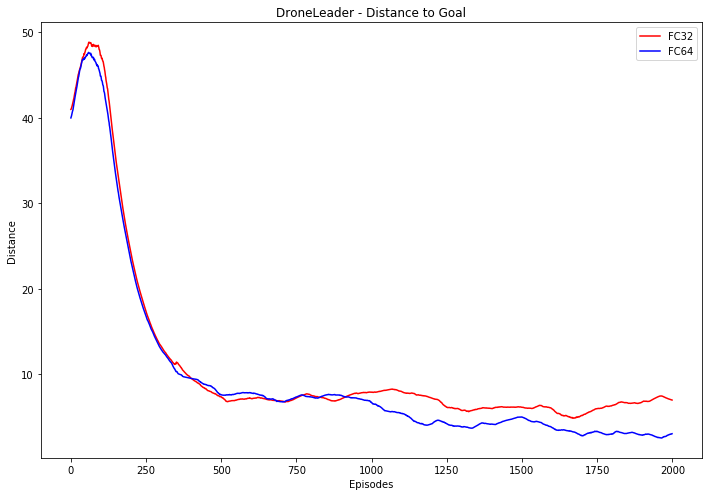

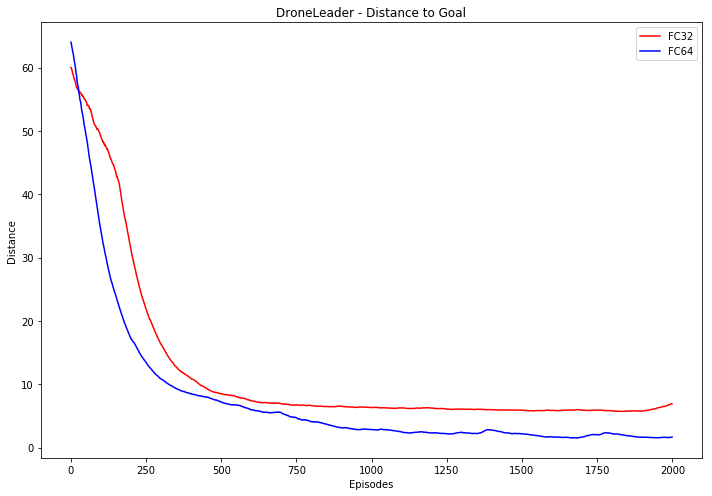

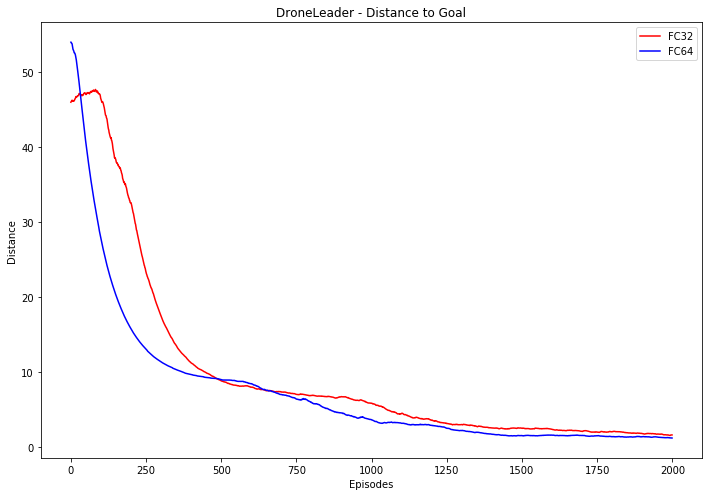

In [31]:
game = 'Crossing'

############# 1T1L Strategist + Simple DroneLeader #############
dir_names = [
    "results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc32_seed_0/t2.0_rp-1.0_300gs/",   # scenario=36
    "results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc32_seed_7/t2.0_rp-1.0_300gs/",   # scenario=37
    "results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc32_seed_54/t2.0_rp-1.0_300gs/",  # scenario=38
    "results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_0/t2.0_rp-1.0_300gs/",   # scenario=39
    "results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_7/t2.0_rp-1.0_300gs/",   # scenario=40
    "results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_54/t2.0_rp-1.0_300gs/"   # scenario=41
]

data = []

for i, dir_name in enumerate(dir_names):
    print (dir_name)
   
    delta_file = dir_name+'Delta.p'.format(i, game)
    with open(delta_file, 'rb') as f:
        data.append(pickle.load(f))
            
plt.figure(figsize=(10, 7))

plt.plot(data[0], label='FC32', color='red')
plt.plot(data[3], label='FC64', color='blue')

plt.title('DroneLeader - Distance to Goal')
plt.xlabel('Episodes')
plt.ylabel('Distance')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))

plt.plot(data[1], label='FC32', color='red')
plt.plot(data[4], label='FC64', color='blue')

plt.title('DroneLeader - Distance to Goal')
plt.xlabel('Episodes')
plt.ylabel('Distance')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))

plt.plot(data[2], label='FC32', color='red')
plt.plot(data[5], label='FC64', color='blue')

plt.title('DroneLeader - Distance to Goal')
plt.xlabel('Episodes')
plt.ylabel('Distance')
plt.legend()
plt.tight_layout()
plt.show()

## Step Reward

We increase the reward of the drone leader staying at the target coordinate from 1.0 to 3.0, and it results in no change at all to the learning trajectories.

This is counter-intuitive!

results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_0/t2.0_rp-1.0_300gs/
results/1T-1L/strategist_step_reward/food_d37_river_w1_d25/droneleaderfc64_seed_0/t2.0_rp-1.0_300gs/
results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_7/t2.0_rp-1.0_300gs/
results/1T-1L/strategist_step_reward/food_d37_river_w1_d25/droneleaderfc64_seed_7/t2.0_rp-1.0_300gs/
results/1T-1L/strategist_big_reward/food_d37_river_w1_d25/droneleaderfc64_seed_7/t2.0_rp-1.0_300gs/
results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_54/t2.0_rp-1.0_300gs/
results/1T-1L/strategist_step_reward/food_d37_river_w1_d25/droneleaderfc64_seed_54/t2.0_rp-1.0_300gs/


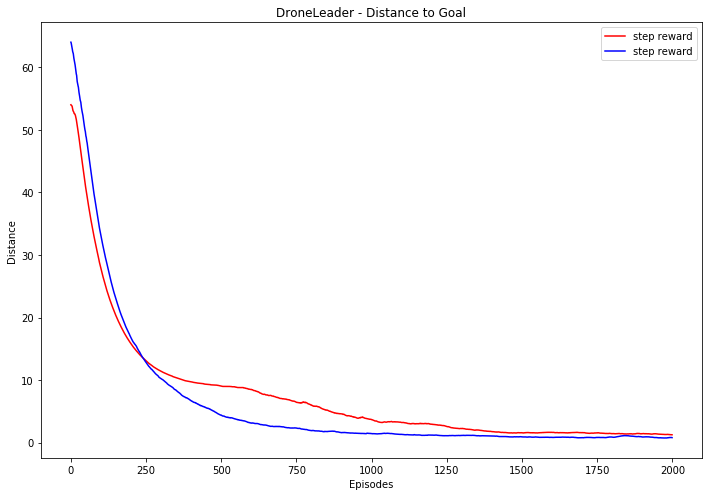

In [5]:
game = 'Crossing'

############# 1T1L Strategist + Simple DroneLeader #############
dir_names = [
    "results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_0/t2.0_rp-1.0_300gs/",   # scenario=36
    "results/1T-1L/strategist_step_reward/food_d37_river_w1_d25/droneleaderfc64_seed_0/t2.0_rp-1.0_300gs/",   # scenario=37
    "results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_7/t2.0_rp-1.0_300gs/",
    "results/1T-1L/strategist_step_reward/food_d37_river_w1_d25/droneleaderfc64_seed_7/t2.0_rp-1.0_300gs/",   # scenario=37
    "results/1T-1L/strategist_big_reward/food_d37_river_w1_d25/droneleaderfc64_seed_7/t2.0_rp-1.0_300gs/",   # scenario=37
    "results/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_54/t2.0_rp-1.0_300gs/",
    "results/1T-1L/strategist_step_reward/food_d37_river_w1_d25/droneleaderfc64_seed_54/t2.0_rp-1.0_300gs/",   # scenario=37
]

data = []

for i, dir_name in enumerate(dir_names):
    print (dir_name)
   
    delta_file = dir_name+'Delta.p'.format(i, game)
    with open(delta_file, 'rb') as f:
        data.append(pickle.load(f))
            
plt.figure(figsize=(10, 7))


plt.plot(data[6], label='step reward', color='red')
plt.plot(data[4], label='step reward', color='blue')

plt.title('DroneLeader - Distance to Goal')
plt.xlabel('Episodes')
plt.ylabel('Distance')
plt.legend()
plt.tight_layout()
plt.show()